In [52]:
# Load a pdf with langchain PyPDFLoader
from langchain.document_loaders import PyPDFLoader
import openai
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Helper Functions

In [50]:
def load_paper(file_path="./paper.pdf"):
    loader = PyPDFLoader(file_path)
    docs = loader.load()
    return docs


def create_qa(context, num=5):
    # Defining the context for creating the Q&As
    # Prompt to create the questions
    q_a_prompt = f"Create a set of {num} questions with answers based solely on this text from a paper:\n\n{context}\n\n. Separate each block composed of a question and an answer with 3 dashes '---' like this Q: <question>\n A:<answer> --- Q: <question>\n A:<answer> etc.... Let's think step by step. Q:"
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "system", "content": "You are a helpful research and\
            programming assistant"},
                  {"role": "user", "content": q_a_prompt}]
    )
    
    return response["choices"][0]["message"]["content"]


def evaluate_answer(question, true_answer, user_answer):
    # Evaluate the answer
    evaluate_prompt = f"Given this question: {question} for which the correct answer is this: {true_answer}, give a score from 0 to 100 to the following answer given by the user: {user_answer}. The output should be formmated as follows: SCORE: <score number as an integer (e.g 45, 90, etc...)> \n: FEEDBACK: <A one sentence feedback justifying the score.>"
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages = [{"role": "system", "content": "You are a helpful research and\
            programming assistant"},
                    {"role": "user", "content": evaluate_prompt}]
    )

    return response["choices"][0]["message"]["content"]

CORRECT ANSWER:   VideoTaskformer is a pre-trained video model focused on representing the semantics and structure of instructional videos. It learns step representations globally, leveraging video of the entire surrounding task as context, whereas prior works learn step representations locally from single short video clips independent of the task, lacking knowledge of task structure.
***
SCORE: 90
***
FEEDBACK:  The answer accurately describes VideoTaskformer as a pre-trained video model that represents the semantics and structure of instructional videos, but lacks the detail that it learns step representations globally and leverages the surrounding task as context.
*********
ROUND SCORE: 90.0
CORRECT ANSWER:   The goal of the Mistake Step Detection task is to identify which step in a video is incorrect. The input consists of a video V with K steps, where one randomly selected step is replaced with a step from a different video V2. The task is to predict the index of the incorrect ste

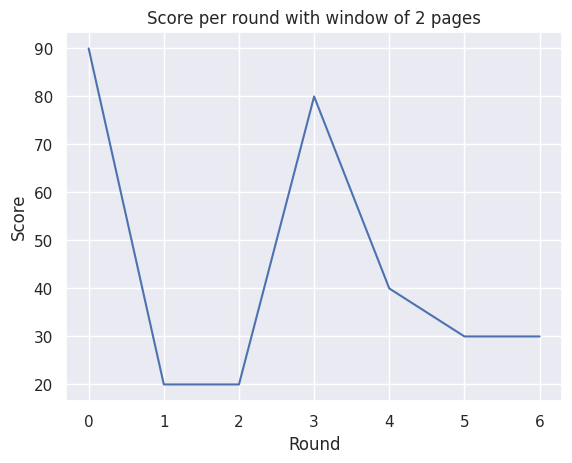

The Q&A data:  {'Round 0': {'question': 'What is VideoTaskformer and how is it different from prior works?\n\n', 'answer': ' VideoTaskformer is a pre-trained video model focused on representing the semantics and structure of instructional videos. It learns step representations globally, leveraging video of the entire surrounding task as context, whereas prior works learn step representations locally from single short video clips independent of the task, lacking knowledge of task structure.', 'user_answer': 'Pre-trained video model that represents semantics and structure of instructional videos'}, 'Round 1': {'question': 'What is the goal of the Mistake Step Detection task and how is it performed?\n\n', 'answer': ' The goal of the Mistake Step Detection task is to identify which step in a video is incorrect. The input consists of a video V with K steps, where one randomly selected step is replaced with a step from a different video V2. The task is to predict the index of the incorrect s

In [51]:
# User specified number of questions for each round of Q&A.
num = 1
# Specify the number of pages to give as context for the Q&A
context_window = 2
overall_scores = []
qa_dict = {}
for i,page_num in enumerate(range(0, len(docs),context_window)):
    # Concatenating the pages (set by the context_window) to give as context for the Q&A
    context = "".join([page.page_content for page in docs[page_num:page_num+context_window]])
    q_a = create_qa(context, num)
    # Create a list of questions and answers from the output string by leveraging the '---' separator
    q_a_list = q_a.split('---')
    scores_list = []
    for qa in q_a_list:
        question = qa.split("A:")[0].replace("Q:", "")
        answer = qa.split("A:")[1].replace("Q:", "")
        user_answer = input(question)
        qa_dict[f"Round {i}"] = {"question": question, "answer": answer, "user_answer": user_answer}
        print("CORRECT ANSWER: ", answer)
        print("***")
        score_feedback = evaluate_answer(question, answer, user_answer)
        score = score_feedback.split("SCORE:")[1].split("FEEDBACK:")[0]
        try:
            feedback = score_feedback.split("FEEDBACK:")[1]
        except:
            feedback = "Error getting feedback"
        # write a check to make sure the output can be turned into an integer
        try:
            score = int(score)
        except:
            print("The score could not be converted to an integer. Please try again.")
            print("The output score was: ", score)
        if type(score)==int:
            scores_list.append(score)
        print("SCORE:", score)
        print("***")
        print("FEEDBACK:", feedback)
        print("*********")
    round_score = sum(scores_list)/len(scores_list)
    print("ROUND SCORE:", round_score)
    overall_scores.append(round_score)
    continue_input = input("Press enter to continue or type 'q' to quit the Q&A session")
    if continue_input=='q':
        break


print("OVERALL SCORE:", sum(overall_scores)/len(overall_scores))
plt.plot(overall_scores)
plt.xlabel("Round")
plt.ylabel("Score")
plt.title("Score per round with window of 2 pages")
plt.show()

print("The Q&A data: ", qa_dict)